In [82]:
import spotipy as spt
import dotenv
from langsmith import Client

dotenv.load_dotenv()

client = Client()

## Spotify Authentication

In [3]:
from spotipy.oauth2 import SpotifyOAuth

SCOPE = 'user-modify-playback-state user-library-read user-read-email user-read-private user-top-read user-modify-playback-state user-read-playback-state'
REDIRECT_URI = 'http://localhost:8888/callback'

sp = spt.Spotify(auth_manager=SpotifyOAuth(scope=SCOPE, redirect_uri=REDIRECT_URI))


## Current playlists

In [4]:
results = sp.current_user_playlists(limit=50)
for i, item in enumerate(results['items']):
    print("%d %s" % (i, item['name']))

0 synth
1 instrumental/jazzy
2 indie
3 m
4 roadtrip
5 alt
6 hip hop
7 house
8 classic hiphop
9 retro groovy
10 classical
11 Demolition Soundtrack


## Liked songs

In [5]:
import json

results = sp.current_user_saved_tracks(limit=50)
for idx, item in enumerate(results['items']):
    track = item['track']
    print(idx, track['artists'][0]['name'], " – ", track['name'])

# dump results to json
with open('experimental/50-last-liked-tacks-results.json', 'w') as f:
    json.dump(results, f)

0 Frankie Stew and Harvey Gunn  –  Skimming Stones
1 Thee Sacred Souls  –  Easier Said Than Done
2 Tash Sultana  –  Notion
3 Masego  –  Navajo
4 Robohands  –  Whole
5 Fog Lake  –  Almost Fantasy
6 Turnover  –  Temporary Love
7 Patrick Watson  –  Je te laisserai des mots
8 Jóhann Jóhannsson  –  A Sparrow Alighted Upon Our Shoulder
9 The Strokes  –  At The Door
10 Jeff Buckley  –  Lover, You Should've Come Over
11 Grizzly Bear  –  Ready, Able
12 Declan McKenna  –  Brazil
13 Sticky Fingers  –  Rum Rage
14 Her  –  Her
15 My Morning Jacket  –  Tyrone
16 Current Joys  –  Fear
17 Dream, Ivory  –  Amateur Night
18 .com  –  Lover For Tonight
19 Harmless  –  Pier Café
20 No Vacation  –  Waltzing Back
21 Beach Vacation  –  Lost In Sight
22 Depeche Mode  –  Enjoy the Silence
23 Tame Impala  –  Jeremy's Storm
24 LCD Soundsystem  –  Home
25 The Afghan Whigs  –  Algiers
26 A Tribe Called Quest  –  Conrad Tokyo (feat. Kendrick Lamar & Jack White)
27 Drake  –  Yebba’s Heartbreak
28 ALYSS  –  Pyramid
29

### Curate tracks dataset

In [6]:
liked_songs_size = sp.current_user_saved_tracks(limit=1)['total']
batch_size = 50
liked_songs = []
for i in range(0, liked_songs_size, batch_size):
    results = sp.current_user_saved_tracks(limit=batch_size, offset=i)
    for idx, item in enumerate(results['items']):
        track = {}
        track['added_at'] = item['added_at']
        track['id'] = item['track']['id']
        track['uri'] = item['track']['uri']
        track['name'] = item['track']['name']
        track['popularity'] = item['track']['popularity']
        track['track_number'] = item['track']['track_number'] # order in album
        track['disc_number'] = item['track']['disc_number'] # which disc in album
        track['explicit'] = item['track']['explicit']
        track['duration_ms'] = item['track']['duration_ms']
        track['album_id'] = item['track']['album']['id']
        track['album_name'] = item['track']['album']['name']
        track['album_uri'] = item['track']['album']['uri']
        track['artists'] = [artist['id'] for artist in item['track']['artists']]
        liked_songs.append(track)

with open('experimental/liked_songs.json', 'w') as f:
    json.dump(liked_songs, f)

In [7]:
f"There are {len(liked_songs)} liked songs."

'There are 356 liked songs.'

In [8]:
# get audio features
sp.audio_features(['4zIeRcsaho6lZuaXEYR1y3'])

[{'danceability': 0.547,
  'energy': 0.399,
  'key': 10,
  'loudness': -9.808,
  'mode': 1,
  'speechiness': 0.0246,
  'acousticness': 0.668,
  'instrumentalness': 2.81e-06,
  'liveness': 0.132,
  'valence': 0.563,
  'tempo': 84.127,
  'type': 'audio_features',
  'id': '4zIeRcsaho6lZuaXEYR1y3',
  'uri': 'spotify:track:4zIeRcsaho6lZuaXEYR1y3',
  'track_href': 'https://api.spotify.com/v1/tracks/4zIeRcsaho6lZuaXEYR1y3',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/4zIeRcsaho6lZuaXEYR1y3',
  'duration_ms': 174707,
  'time_signature': 4}]

In [9]:
audio_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

for i in range(0, len(liked_songs), 50):
    ids = [song['id'] for song in liked_songs[i:i+50]]
    features = sp.audio_features(ids)
    for idx, feature in enumerate(features):
        for af in audio_features:
            liked_songs[i+idx][af] = feature[af]

with open('experimental/liked_songs_with_audio_features.json', 'w') as f:
    json.dump(liked_songs, f)


### Curate albums dataset

In [159]:
sp.album('6ofJrAZaaX0iWTXYXObUxE')['name']

'Thee Sacred Souls'

In [11]:
album_ids = list(set([song['album_id'] for song in liked_songs]))
albums = []
for i in range(0, len(album_ids), 20):
    ids = album_ids[i:i+20]
    for a in sp.albums(ids)['albums']:
        album = {}
        album['id'] = a['id']
        album['uri'] = a['uri']
        album['type'] = a['album_type']
        album['total_tracks'] = a['total_tracks']
        album['name'] = a['name']
        album['release_date'] = a['release_date']
        album['release_date_precision'] = a['release_date_precision']
        album['artists'] = [artist['id'] for artist in a['artists']]
        album['tracks'] = [track['id'] for track in a['tracks']['items']]
        album['genres'] = a['genres']
        album['label'] = a['label']
        album['popularity'] = a['popularity']
        albums.append(album)

print(f"There are {len(albums)} albums in the liked songs")

with open('experimental/albums.json', 'w') as f:
    json.dump(albums, f)

There are 336 albums in the liked songs


In [12]:
f"There are {len(liked_songs)} liked songs."

'There are 356 liked songs.'

In [13]:
len(set([a['name'] for a in albums]))

335

In [14]:
# which two albums have the same name?
from collections import Counter
album_names = [a['name'] for a in albums]
album_name_counter = Counter(album_names)
duplicates = {k: v for k, v in album_name_counter.items() if v > 1}
duplicates

{'Waltzing Back': 2}

In [15]:
[a for a in albums if a['name'] == 'Waltzing Back']

[{'id': '5yHn5NJqFHuRscn44o9POq',
  'uri': 'spotify:album:5yHn5NJqFHuRscn44o9POq',
  'type': 'single',
  'total_tracks': 1,
  'name': 'Waltzing Back',
  'release_date': '2021-07-14',
  'release_date_precision': 'day',
  'artists': ['32zeX1IoVKAGWMyy1isKUq'],
  'tracks': ['3Q1DprZauQyNo8KGlY8brZ'],
  'genres': [],
  'label': 'Topshelf Records',
  'popularity': 0},
 {'id': '5j49mR7hcvrACDJZNVTmpu',
  'uri': 'spotify:album:5j49mR7hcvrACDJZNVTmpu',
  'type': 'single',
  'total_tracks': 1,
  'name': 'Waltzing Back',
  'release_date': '2021-07-14',
  'release_date_precision': 'day',
  'artists': ['32zeX1IoVKAGWMyy1isKUq'],
  'tracks': ['3JcvpTfI64SmXxUl7XUvQI'],
  'genres': [],
  'label': 'Topshelf Records',
  'popularity': 46}]

This looks like an error.

In [16]:
# get all genres
genres = set()
for a in albums:
    genres.update(set(a['genres']))

f"There are {len(genres)} genres from albums"

'There are 0 genres from albums'

Seems like genres have not been annotated for the albums.

### Curate artists dataset

In [17]:
artist_ids_from_albums = set([artist for album in albums for artist in album['artists']])
artist_ids_from_songs = set([artist for song in liked_songs for artist in song['artists']])
artist_ids = artist_ids_from_albums.union(artist_ids_from_songs)

In [18]:
from tqdm import tqdm

artists = []
for i in range(0, len(artist_ids), 50):
    ids = list(artist_ids)[i:i+50]
    for a in tqdm(sp.artists(ids)['artists']):
        artist = {}
        artist['id'] = a['id']
        artist['uri'] = a['uri']
        artist['name'] = a['name']
        artist['genres'] = a['genres']
        artist['popularity'] = a['popularity']
        artist['followers'] = a['followers']['total']
        artist['albums'] = [album['id'] for album in sp.artist_albums(a['id'])['items']]
        artist['top_tracks'] = [track['id'] for track in sp.artist_top_tracks(a['id'])['tracks']]
        artists.append(artist)

with open('experimental/artists.json', 'w') as f:
    json.dump(artists, f)

f"There are {len(artists)} artists."

100%|██████████| 36/36 [00:15<00:00,  2.40it/s]


'There are 336 artists.'

In [19]:
[track['id'] for track in sp.artist_top_tracks('37w38cCSGgKLdayTRjna4W')['tracks']]

['1LzNfuep1bnAUR9skqdHCK',
 '6JuEshIRliNXRU1LXctRjZ',
 '010ALbbh5KlQ4fKWgSdhRd',
 '3BdHMOIA9B0bN53jbE5nWe',
 '3R6kyOmqWcAsqZqqe9CGL0',
 '7l5nkTZpoD93OkynN0gcon',
 '2qV5Ce0sMlFsrseRO5CTMU',
 '7Gwi3AOnlyXkt6yJzU3BmM',
 '7pfqtkZsNheOoDziqquDT3',
 '4V79NKNUFkjzHWcPLtdlNM']

In [20]:
genres = set()
for a in artists:
    genres.update(set(a['genres']))

f"There are {len(genres)} genres from artists"

'There are 382 genres from artists'

In [21]:
genres = list()
for song in liked_songs:
    artist_ids = song['artists']
    for artist_id in artist_ids:
        artist = [a for a in artists if a['id'] == artist_id][0]
        genres.extend(artist['genres'])

from collections import Counter
genre_counter = Counter(genres)
genre_counter.most_common(30)

[('indietronica', 35),
 ('rock', 32),
 ('modern rock', 31),
 ('indie rock', 29),
 ('alternative rock', 28),
 ('electronica', 24),
 ('permanent wave', 19),
 ('hip hop', 18),
 ('pov: indie', 17),
 ('rap', 16),
 ('neo-psychedelic', 14),
 ('melancholia', 13),
 ('chamber pop', 13),
 ('neo-synthpop', 12),
 ('stomp and holler', 12),
 ('dream pop', 12),
 ('indie soul', 11),
 ('art pop', 11),
 ('modern dream pop', 11),
 ('modern alternative rock', 11),
 ('downtempo', 10),
 ('art rock', 10),
 ('indie folk', 9),
 ('alternative dance', 9),
 ('oxford indie', 9),
 ('shoegaze', 9),
 ('lo-fi indie', 8),
 ('compositional ambient', 8),
 ('indie garage rock', 8),
 ('conscious hip hop', 8)]

In [22]:
# save the genre counter in order
with open('experimental/genre_counter.json', 'w') as f:
    json.dump(genre_counter.most_common(len(genre_counter)), f)

In [23]:
# get the average number of genres per artist
from statistics import mean
mean([len(a['genres']) for a in artists])

2.550595238095238

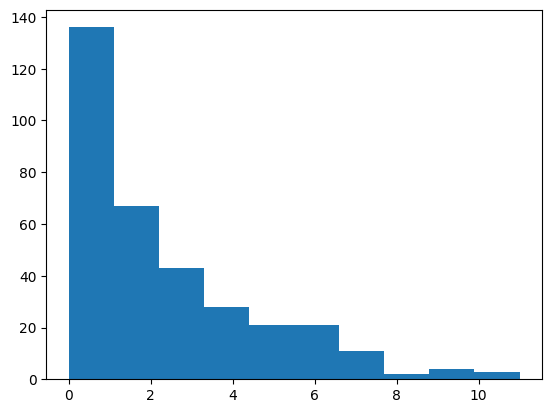

In [24]:
# plot the distribution of the number of genres per artist in 10 bins
import matplotlib.pyplot as plt
plt.hist([len(a['genres']) for a in artists], bins=10)
plt.show()


In [25]:
# get artists with more than 8 genres
[a['name'] for a in artists if len(a['genres']) > 8]

['DIIV',
 'Jack White',
 'Leon Vynehall',
 'Grouper',
 'Arcade Fire',
 'LCD Soundsystem',
 'Joy Division']

In [26]:
# get arcades fire
[a['genres'] for a in artists if a['name'] == 'Arcade Fire'][0]

['alternative rock',
 'baroque pop',
 'canadian indie',
 'canadian indie rock',
 'chamber pop',
 'indie rock',
 'indietronica',
 'modern rock',
 'permanent wave',
 'quebec indie',
 'rock']

## Genre information retrieval

In [27]:
import requests
import os

def get_top_tags(api_key, artist, track, mbid=None, autocorrect=None):
    url = "http://ws.audioscrobbler.com/2.0/"
    params = {
        "method": "track.getTopTags",
        "artist": artist,
        "track": track,
        "api_key": api_key,
        "format": "json"  # You can change the format to "xml" if you prefer XML response
    }
    if mbid:
        params["mbid"] = mbid
    if autocorrect is not None:
        params["autocorrect"] = autocorrect

    response = requests.get(url, params=params)
    data = response.json()
    return data


In [28]:
last_fm_api_key = os.getenv("LAST_FM_API_KEY")
artist = "Coldplay"
track = "Yellow"
result = get_top_tags(last_fm_api_key, artist, track)
# save the result to a file
with open('experimental/last_fm_top_tags_coldplay_yellow.json', 'w') as f:
    json.dump(result, f)

In [29]:
for song in liked_songs[10:20]:
    for artist_id in song['artists']:
        artist = [a for a in artists if a['id'] == artist_id][0]
        tags = get_top_tags(last_fm_api_key, artist['name'], song['name'])
        if 'toptags' in tags and 'tag' in tags['toptags']:
            top_tags = tags['toptags']['tag']
            if len(top_tags) > 0:
                ts = [(t['name'], t['count']) for t in top_tags]
                print(f"Top tags for {artist['name']} - {song['name']} is {ts}")


Top tags for Jeff Buckley - Lover, You Should've Come Over is [('singer-songwriter', 100), ('rock', 81), ('beautiful', 52), ('Love', 47), ('jeff buckley', 46), ('Mellow', 29), ('indie', 25), ('alternative', 24), ('alternative rock', 21), ('90s', 21), ('acoustic', 17), ('sad', 16), ('favorites', 15), ('melancholy', 13), ('folk', 12), ('melancholic', 12), ('chillout', 11), ('chill', 11), ('favorite songs', 11), ('emotional', 10), ('male vocalists', 10), ('Favorite', 10), ('american', 9), ('pop', 8), ('indie rock', 8), ('Awesome', 8), ('guitar', 8), ('Masterpiece', 8), ('Perfection', 7), ('great lyrics', 6), ('easy listening', 5), ('genius', 5), ('amazing', 5), ('folk rock', 5), ('intense', 5), ('Favourites', 5), ('romance', 5), ('lover', 5), ('heartbroken', 5), ('classic rock', 4), ('epic', 4), ('romantic', 4), ('dramatic', 4), ('relax', 4), ('love at first listen', 4), ('1994', 4), ('vule', 4), ('love-sickness emergency-care-kitt', 4), ('love hurts', 4), ('vocal', 3), ('atmospheric', 3)

Looks like the top tags contains unrelated information to genre. We will develop a method that will extract the genre information from the top tags.

## Defining a taxonomy

For this it is also important to define a taxonomy of genres.
- [Automatic Genre Classification of Musical Signals](https://www.researchgate.net/publication/26620180_Automatic_Genre_Classification_of_Musical_Signals)

MUSIC
- Classical
  - Instrumental
    - Piano
    - Orchestra
  - Vocal
    - Opera
    - Chorus
- Dance
  - Vocal
    - Hip-Hop
    - Reggae
  - Percussion
    - Jazz
    - Latin
- Pop/Rock
  - Organic
    - Rock
    - Country
  - Electronic
    - Pop
    - Techno

This taxonomy could work if the dataset is balanced. However, it is not the case. Large proportion of the dataset is pop/rock. This implies the taxonomy should be more detailed on that branch, however, the further down the branch we go, the more ambgiuous and subjective the classification becomes, as the genres are more similar to each other, the decision boundary becomes more blurred.

In [30]:
len(genre_counter), len(liked_songs)

(377, 356)

The idea is to use the combination of top tags and spotify's artist level genre information to extract the relevant genre classes for each song. Since there is high variability in the top tags (sometimes it is not even genre), as well as the artist level genre information is too specific (377 genres for 355 songs), it is very hard to come up with a rule based system to extract the genre information. Therefore, we will use a large language models to extract the genre information from the top tags and artist level genre information, utiliziing their intrinsic knowledge of the language and reasoning capabilities.

Using a large langauge model, we also created a taxonomy of genres, which is more tailored to the dataset. The taxonomy is as follows:
MUSIC
- Rock
  - Alternative Rock
  - Indie Rock
  - Modern Rock
  - Punk
  - Grunge
- Electronic
  - Electronica
  - EDM
  - House
  - Techno
  - Synthwave
- Hip Hop/Rap
  - Hip Hop
  - Rap
  - Trap
  - Lo-Fi Hip Hop
- Pop
  - Indie Pop
  - Synthpop
  - Pop Rock
  - R&B
- Folk/Country
  - Folk
  - Country
  - Americana
  - Bluegrass
- Experimental/Avant-Garde
  - Experimental
  - Avant-Garde
  - Noise
- World/Fusion
  - World Music
  - Reggae
  - Latin
  - Afrobeat
  - Fusion
- Classical/Jazz
  - Classical
  - Jazz
- Other/Unique
  - Other/Unique


In [72]:
genre_taxonomy = """
- Rock
  - Alternative
  - Indie
  - Classic Rock
- Electronic
  - Electronica
  - EDM
  - House
  - Techno
  - Synthwave
- Hip Hop/Rap
  - Hip Hop
  - Rap
  - Lo-Fi Hip Hop
- Pop
  - Synthpop
  - Indie Pop
  - Pop Rock
  - R&B
- Folk/World
  - Folk
  - Americana
  - World Music
  - Reggae
  - Country
- Classical/Jazz
  - Classical
  - Jazz
  - Blues
- Other
  - Other
"""

In [137]:
subgenres = {
    "alternative": "rock",
    "indie": "rock",
    "classic rock": "rock",
    "electronica": "electronic",
    "edm": "electronic",
    "house": "electronic",
    "techno": "electronic",
    "synthwave": "electronic",
    "hip hop": "hip hop/rap",
    "rap": "hip hop/rap",
    "lo-fi hip hop": "hip hop/rap",
    "indie pop": "pop",
    "synthpop": "pop",
    "pop rock": "pop",
    "r&b": "pop",
    "folk": "folk/world",
    "country": "folk/world",
    "americana": "folk/world",
    "reggae": "folk/world",
    "classical": "classical/jazz",
    "jazz": "classical/jazz",
    "other": "other",
}

### Using gpt-4 turbo with langchain to infer genres

The pydantic model below is needed for structured output parsing of LLMs.

In [98]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional
from langchain_core.prompts import ChatPromptTemplate
from enum import Enum

class Genre(str, Enum):
    Alternative_Rock = "alternative"
    Indie_Rock = "indie"
    Classic_Rock = "classic rock"
    Electronica = "electronica"
    EDM = "edm"
    House = "house"
    Techno = "techno"
    Synthwave = "synthwave"
    Hip_Hop = "hip hop"
    Rap = "rap"
    Lo_Fi_Hip_Hop = "lo-fi hip hop"
    Indie_Pop = "indie pop"
    Synthpop = "synthpop"
    Pop_Rock = "pop rock"
    R_B = "r&b"
    Folk = "folk"
    Country = "country"
    Americana = "americana"
    Reggae = "reggae"
    Classical = "classical"
    Jazz = "jazz"
    Other = "other"

class Song(BaseModel):
    id: str = Field(..., description="The spotify id of a song")
    name: str = Field(..., description="The name of a song")
    sub_genre: str = Field(..., description=f"The sub-genre of a song, possible values are {', '.join([g.value for g in Genre])}")
    # this directly implies the parent genre

class Songs(BaseModel):
    songs: List[Song] = Field(
        default=None,
        title="List of songs containing id, name and sub-genre",
    )

In [91]:
song_genre_prompt = ChatPromptTemplate.from_template(
    """
    You are a music expert and you are tasked with categorizing songs into sub-genres. You have access to the following information:
    
    - A list of songs and their corresponding context. You are given the top tags for each song from Last.fm, and the tag's score. In some cases, the tags contain genres, in others they might contain unrelated information. Sometimes there are non-genre related information with a high score. You should only take into account the tags that are related to genres. Sometimes the tags that are related to genres might have a different name like 'indie rock' instead of 'indie'. Use the genre taxonomy to map these tags to the genres. You should only consider the tags that are related to genres.
    On top of this, you are given all the spotify genres, that were extracted from the song's artists. You need to use this information and your previous knowledge to extract which sub-genre each song belongs to. These spotify genres are very specific and you should not use them directly as sub-genres. You should use the list of availabel sub-genres to map these genres to the sub-genres.
    Here are the songs you need to categorize with the above-mentioned context:
    {list_of_songs_with_context}
    
    - The list of sub-genres that you need to base the categorization on:
    {genre_taxonomy}
    Make sure that when you classify a song into a sub-genre, you can only select one from the list you are given. Do NOT come up with new sub-genres.
    Make sure you return ALL of the songs that you were given in the list, with the sub-genre that you have assigned to them. You can only assign one sub-genre to each song. PAY SPECIAL ATTENTION to the fact that there is a pool of genres that you need to choose from, and you should not come up with new ones. THIS IS VERY IMPORTANT.
    """
)


Spotify genre context.

In [35]:
spotify_artist_genres_by_song = {}
for song in liked_songs:
    for artist_id in song['artists']:
        artist = [a for a in artists if a['id'] == artist_id][0]
        if song['id'] not in spotify_artist_genres_by_song:
            spotify_artist_genres_by_song[song['id']] = set()
        spotify_artist_genres_by_song[song['id']].update(set(artist['genres']))

In [160]:
spotify_artist_genres_by_song['0V5cvmTKsYmF5FmGGEAfmS']

{'indie folk', 'indie quebecois'}

Last fm genre context.

In [37]:
top_tags_by_song = {}
for song in tqdm(liked_songs):
    for artist_id in song['artists']:
        artist = [a for a in artists if a['id'] == artist_id][0]
        tags = get_top_tags(last_fm_api_key, artist['name'], song['name'])
        if 'toptags' in tags and 'tag' in tags['toptags']:
            top_tags = tags['toptags']['tag']
            if len(top_tags) > 0:
                ts = [(t['name'], t['count']) for t in top_tags if len(t['name']) > 2] # filter out tags with less than 3 characters
                top_tags_by_song[song['id']] = ts[:10] # only take the top 10 tags

100%|██████████| 356/356 [01:09<00:00,  5.16it/s]


In [38]:
top_tags_by_song.get('0V5cvmTKsYmF5FmGGEAfmS')

[('french', 100),
 ('indie', 100),
 ('beautiful', 100),
 ('beauty', 100),
 ('indie folk', 100),
 ('Ballad', 100),
 ('personal favourites', 100),
 ('amour', 100),
 ('JessicAnime', 100),
 ('MySpotigramBot', 100)]

- construct context for prompt
- create batches of 10, shoudl be 36 batches, 36 requests to LLM

In [114]:
# iterate with X intervals through liked songs
batch_size = 4
batches_of_songs_with_context = []
for i in tqdm(range(0, len(liked_songs), batch_size)):
    songs = liked_songs[i:i+batch_size]
    songs_with_context = []
    for song in songs:
        context = {
            "spotify_genres": list(spotify_artist_genres_by_song[song['id']]),
            "last_fm_tags": top_tags_by_song.get(song['id'], {})
        }
        songs_with_context.append({
            "id": song['id'],
            "name": song['name'],
            "context": context
        })
    batches_of_songs_with_context.append(songs_with_context)

100%|██████████| 89/89 [00:00<00:00, 25222.50it/s]


In [161]:
batches_of_songs_with_context[1]

[{'id': '7dt7CivUMrw2VWyhT8ffbT',
  'name': 'Whole',
  'context': {'spotify_genres': ['uk contemporary jazz', 'indie jazz'],
   'last_fm_tags': {}}},
 {'id': '30U7MwsSebniOJyZ8y1hcE',
  'name': 'Almost Fantasy',
  'context': {'spotify_genres': ['newfoundland indie',
    'lo-fi indie',
    'small room'],
   'last_fm_tags': [('emo', 100)]}},
 {'id': '2DL6nA2xnGCeAGW296ZEe8',
  'name': 'Temporary Love',
  'context': {'spotify_genres': ['emo',
    'alternative emo',
    'chill dream pop',
    'dreamo'],
   'last_fm_tags': {}}},
 {'id': '0V5cvmTKsYmF5FmGGEAfmS',
  'name': 'Je te laisserai des mots',
  'context': {'spotify_genres': ['indie folk', 'indie quebecois'],
   'last_fm_tags': [('french', 100),
    ('indie', 100),
    ('beautiful', 100),
    ('beauty', 100),
    ('indie folk', 100),
    ('Ballad', 100),
    ('personal favourites', 100),
    ('amour', 100),
    ('JessicAnime', 100),
    ('MySpotigramBot', 100)]}}]

In [115]:
from langchain_openai import ChatOpenAI

long_context_llm = ChatOpenAI(model="gpt-4-turbo-preview", temperature=0.4)
genre_classifier = song_genre_prompt | long_context_llm.with_structured_output(
    Songs
)

In [116]:
classified_songs = genre_classifier.invoke(
    {
        "genre_taxonomy": {', '.join([g.value for g in Genre])},
        "list_of_songs_with_context": batches_of_songs_with_context[1]
    }
)

In [119]:
classified_songs = []
for batch in tqdm(batches_of_songs_with_context):
    cl_songs = genre_classifier.invoke(
        {
            "genre_taxonomy": {', '.join([g.value for g in Genre])},
            "list_of_songs_with_context": batch
        }
    )
    classified_songs.extend(cl_songs.songs)

100%|██████████| 89/89 [06:44<00:00,  4.55s/it]


In [136]:
for song in classified_songs[:5]:
    print(f"{song.name} is classified as {song.sub_genre}")

Skimming Stones is classified as hip hop
Easier Said Than Done is classified as other
Notion is classified as reggae
Navajo is classified as r&b
Whole is classified as jazz


In [124]:
len(classified_songs)

356

### Validate the inferred genres

In [129]:
# check if the taxonomy actually contains these
not_in_taxonomy = {}
for song in classified_songs:
    if song.sub_genre not in [g.value for g in Genre]:
        print(f"{song.sub_genre} is not in the subgenres")
        not_in_taxonomy[song.id] = song.sub_genre

indie folk is not in the subgenres
indie folk is not in the subgenres
funk is not in the subgenres
garage rock is not in the subgenres
chill pop is not in the subgenres
hungarian rock is not in the subgenres
emo is not in the subgenres
indie rock is not in the subgenres
trip hop is not in the subgenres
psychedelic is not in the subgenres
indie rock is not in the subgenres
indie rock is not in the subgenres
psychedelic rock is not in the subgenres
shoegaze is not in the subgenres
indie rock is not in the subgenres
shoegaze is not in the subgenres
post-punk is not in the subgenres
indie folk is not in the subgenres
indie rock is not in the subgenres
psychedelic rock is not in the subgenres
dream pop is not in the subgenres
indie rock is not in the subgenres
ambient is not in the subgenres
ambient is not in the subgenres
lo-fi indie is not in the subgenres
indie folk is not in the subgenres
indie rock is not in the subgenres
indie rock is not in the subgenres
psychedelic rock is not in th

In [135]:
set(not_in_taxonomy.values())

{'ambient',
 'chill pop',
 'dream pop',
 'emo',
 'funk',
 'garage rock',
 'hungarian rock',
 'indie folk',
 'indie rock',
 'lo-fi indie',
 'post-punk',
 'psychedelic',
 'psychedelic rock',
 'shoegaze',
 'trip hop'}

In [131]:
# check if all ids are in the liked songs
all([song.id in [s['id'] for s in liked_songs] for song in classified_songs])

True

In [142]:
# check frequency of genres
from collections import Counter
genre_counter = Counter([song.sub_genre for song in classified_songs])
genre_counter

Counter({'indie': 50,
         'electronica': 50,
         'indie pop': 44,
         'other': 39,
         'hip hop': 28,
         'alternative': 20,
         'r&b': 17,
         'classical': 12,
         'synthpop': 11,
         'folk': 10,
         'lo-fi hip hop': 9,
         'house': 8,
         'indie rock': 8,
         'classic rock': 7,
         'pop rock': 5,
         'jazz': 4,
         'indie folk': 4,
         'reggae': 3,
         'americana': 3,
         'psychedelic rock': 3,
         'synthwave': 3,
         'shoegaze': 2,
         'ambient': 2,
         'rap': 2,
         'edm': 1,
         'funk': 1,
         'garage rock': 1,
         'chill pop': 1,
         'hungarian rock': 1,
         'emo': 1,
         'trip hop': 1,
         'psychedelic': 1,
         'post-punk': 1,
         'techno': 1,
         'dream pop': 1,
         'lo-fi indie': 1})

In [134]:
# convert to dict
classified_songs_dict = {song.id: song.sub_genre for song in classified_songs}
# save to file
with open('experimental/classified_songs.json', 'w') as f:
    json.dump(classified_songs_dict, f)

We will go over all misclassified songs and assign the correct genre to them, or adjust the taxonomy if necessary.

In [141]:
for song_id in not_in_taxonomy:
    song = [s for s in liked_songs if s['id'] == song_id][0]
    print(song_id)
    print(f"{song['name']} by {', '.join([a['name'] for a in [a for a in artists if a['id'] in song['artists']]])} is classified as {not_in_taxonomy[song_id]}")
    print(f"spotify genres: {', '.join(spotify_artist_genres_by_song[song_id])}")
    print(f"last fm tags: {top_tags_by_song.get(song_id, {})}")

0V5cvmTKsYmF5FmGGEAfmS
Je te laisserai des mots by Patrick Watson is classified as indie folk
spotify genres: indie folk, indie quebecois
last fm tags: [('french', 100), ('indie', 100), ('beautiful', 100), ('beauty', 100), ('indie folk', 100), ('Ballad', 100), ('personal favourites', 100), ('amour', 100), ('JessicAnime', 100), ('MySpotigramBot', 100)]
54KFQB6N4pn926IUUYZGzK
To Build A Home by Patrick Watson, The Cinematic Orchestra is classified as indie folk
spotify genres: downtempo, nu jazz, indie folk, indie quebecois
last fm tags: [('loneliness after dusk', 100), ('pozytywne wibracje', 100)]
7CH99b2i1TXS5P8UUyWtnM
Them Changes by Thundercat is classified as funk
spotify genres: indie soul, afrofuturism, escape room
last fm tags: [('funk', 100), ('soul', 60), ('electronic', 40), ('jazz', 40), ('jazz fusion', 40), ('Neo-Soul', 40), ('2015', 40), ('imported by drip.feed', 40), ('nu jazz', 20), ('indie', 20)]
76c1AuZodByXM3X2k48wju
Dope on a Rope by The Growlers is classified as garag

For the corrections we used google search, incorporated the top tags and artist level genre information.

In [151]:
classified_songs_dict['0V5cvmTKsYmF5FmGGEAfmS'] = 'indie'
classified_songs_dict['54KFQB6N4pn926IUUYZGzK'] = 'folk'
classified_songs_dict['7CH99b2i1TXS5P8UUyWtnM'] = 'r&b'
classified_songs_dict['4zIeRcsaho6lZuaXEYR1y3'] = 'indie'
classified_songs_dict['56LT08MMJHU6cw27V2ekLi'] = 'indie'
classified_songs_dict['0SbqAmDVwJ0m8lxQZRbuoy'] = 'alternative' # hungary mentioned
classified_songs_dict['1acjIzGS1YUrx6nSuktnqU'] = 'alternative'
classified_songs_dict['4fPBB44eDH71YohayI4eKV'] = 'indie'
classified_songs_dict['5gDWsRxpJ2lZAffh5p7K0w'] = 'r&b'
classified_songs_dict['0BaFtki3CupqritofvTRSj'] = 'indie'
classified_songs_dict['2O5UcpKolgLT8l8yAvEmID'] = 'alternative'
classified_songs_dict['60OY6A1Eyz3a4aPDbV7LV0'] = 'alternative'
classified_songs_dict['1tNwAjyfDSQvFeY5JKDw9b'] = 'indie'
classified_songs_dict['30uvCVEYqgktyLfDcI76Hx'] = 'indie'
classified_songs_dict['629TAjfFRi1ealJowp24bo'] = 'indie'
classified_songs_dict['0oxYB9GoOIDrdzniNdKC44'] = 'indie'
classified_songs_dict['5fbQCQt91LsVgXusFS0CCD'] = 'indie'
classified_songs_dict['44DNg8OmuNKSDkccspGCIP'] = 'indie'
classified_songs_dict['2kkX9IzielZhUBybezdE0m'] = 'indie'
classified_songs_dict['4WFcerMZkAIcIizZYXNNrb'] = 'indie'
classified_songs_dict['26CfdVmYf0hNvP6SJXF0vQ'] = 'electronica'
classified_songs_dict['7brQHA2CgQpcMBiOlfiXYb'] = 'pop rock'
classified_songs_dict['0fMUl0pPjBBhn0iAT7mVHW'] = 'ambient'
classified_songs_dict['40Vj9ZP7n7rwEliCgLPLip'] = 'ambient'
classified_songs_dict['6ZLt6fyonW1xOGMBC9vJPJ'] = 'indie'
classified_songs_dict['6hUTzxvNiJ1c0lYqgoOTBW'] = 'folk'
classified_songs_dict['0I1eFRytp4XRhLCjT6tZm7'] = 'indie'
classified_songs_dict['2ZgJ3fxDrGSi3VKe84YDAe'] = 'indie'
classified_songs_dict['1KcOU0q9AMXV9xi4tSzzCc'] = 'indie'
classified_songs_dict['76c1AuZodByXM3X2k48wju'] = 'alternative'

In [152]:
subgenres = {
    "alternative": "rock",
    "indie": "rock",
    "classic rock": "rock",
    "electronica": "electronic",
    "edm": "electronic",
    "house": "electronic",
    "techno": "electronic",
    "ambient": "electronic", # new one
    "synthwave": "electronic",
    "hip hop": "hip hop/rap",
    "rap": "hip hop/rap",
    "lo-fi hip hop": "hip hop/rap",
    "indie pop": "pop",
    "synthpop": "pop",
    "pop rock": "pop",
    "r&b": "pop",
    "folk": "folk/world",
    "country": "folk/world",
    "americana": "folk/world",
    "reggae": "folk/world",
    "classical": "classical/jazz",
    "jazz": "classical/jazz",
    "other": "other",
}

In [153]:
# check if the taxonomy actually contains these
not_in_taxonomy_2 = {}
for song in classified_songs_dict:
    sub_genre = classified_songs_dict[song]
    if sub_genre not in subgenres:
        print(f"{classified_songs_dict[song]} is not in the subgenres, with song id {song}")
        not_in_taxonomy_2[song] = sub_genre

In [155]:
# add classified songs dict genres to liked songs
for song in liked_songs:
    if song['id'] in classified_songs_dict:
        song['sub_genre'] = classified_songs_dict[song['id']]
        song['main_genre'] = subgenres[song['sub_genre']]
    else:
        print(f"Song {song['name']} with id {song['id']} is not classified")
liked_songs[0]

{'added_at': '2024-05-04T11:21:04Z',
 'id': '4ZZ0RMb49n8hZZvXnxRsjo',
 'uri': 'spotify:track:4ZZ0RMb49n8hZZvXnxRsjo',
 'name': 'Skimming Stones',
 'popularity': 32,
 'track_number': 7,
 'disc_number': 1,
 'explicit': False,
 'duration_ms': 137624,
 'album_id': '0ET7qPmTvZttpRARj5JSBA',
 'album_name': 'The Lakes',
 'album_uri': 'spotify:album:0ET7qPmTvZttpRARj5JSBA',
 'artists': ['1jVvXqdwDHekLwFBamrcUx'],
 'danceability': 0.564,
 'energy': 0.534,
 'key': 7,
 'loudness': -9.234,
 'mode': 1,
 'speechiness': 0.155,
 'acousticness': 0.612,
 'instrumentalness': 0.00409,
 'liveness': 0.104,
 'valence': 0.271,
 'tempo': 86.547,
 'sub_genre': 'hip hop',
 'main_genre': 'hip hop/rap'}

In [156]:
# get frequency or main genres
main_genre_counter = Counter([song['main_genre'] for song in liked_songs])
main_genre_counter

Counter({'rock': 99,
         'pop': 80,
         'electronic': 66,
         'hip hop/rap': 39,
         'other': 38,
         'folk/world': 18,
         'classical/jazz': 16})

In [157]:
# save liked songs with genres
with open('experimental/liked_songs_with_audio_features_and_genres.json', 'w') as f:
    json.dump(liked_songs, f)